# micrograd exercises

1. watch the [micrograd video](https://www.youtube.com/watch?v=VMj-3S1tku0) on YouTube
2. come back and complete these exercises to level up :)

## section 1: derivatives

In [40]:
# here is a mathematical expression that takes 3 inputs and produces one output
from math import sin, cos, exp, log

def f(a, b, c):
  return -a**3 + sin(3*b) - 1.0/c + b**2.5 - a**0.5

print(f(2, 3, 4))

6.336362190988558


In [9]:
# write the function df that returns the analytical gradient of f
# i.e. use your skills from calculus to take the derivative, then implement the formula
# if you do not calculus then feel free to ask wolframalpha, e.g.:
# https://www.wolframalpha.com/input?i=d%2Fda%28sin%283*a%29%29%29

def gradf(a, b, c):
  return [-3*a**2 - 0.5*a**(-0.5), cos(3*b) * 3 + 2.5*b**1.5, + 1*c**(-2)] # todo, return [df/da, df/db, df/dc]

# expected answer is the list of 
ans = [-12.353553390593273, 10.25699027111255, 0.0625]
yours = gradf(2, 3, 4)
for dim in range(3):
  ok = 'OK' if abs(yours[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {yours[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553390593273
OK for dim 1: expected 10.25699027111255, yours returns 10.25699027111255
OK for dim 2: expected 0.0625, yours returns 0.0625


In [13]:
# now estimate the gradient numerically without any calculus, using
# the approximation we used in the video.
# you should not call the function df from the last cell

h = 0.0000001

fd_fa = (f(2 + h, 3, 4) - f(2, 3, 4))/h
fd_fb = (f(2, 3 + h, 4) - f(2, 3, 4))/h
fd_fc = (f(2, 3, 4 + h) - f(2, 3, 4))/h

# -----------
numerical_grad = [fd_fa, fd_fb, fd_fc]
# -----------

for dim in range(3):
  ok = 'OK' if abs(numerical_grad[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553966448771
OK for dim 1: expected 10.25699027111255, yours returns 10.256990385926201
OK for dim 2: expected 0.0625, yours returns 0.06249999628948899


In [57]:
# there is an alternative formula that provides a much better numerical 
# approximation to the derivative of a function.
# learn about it here: https://en.wikipedia.org/wiki/Symmetric_derivative
# implement it. confirm that for the same step size h this version gives a
# better approximation.

h = 0.0000001

fd_fa = (f(2 + h, 3, 4) - f(2 - h, 3, 4))/2*h
fd_fb = (f(2, 3 + h, 4) - f(2, 3 - h, 4))/2*h
fd_fc = (f(2, 3, 4 + h) - f(2, 3, 4 - h))/2*h

# -----------
numerical_grad2 = [fd_fa, fd_fb, fd_fc]
# -----------

for dim in range(3):
  ok = 'OK' if abs(numerical_grad2[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad2[dim]}")


WRONG! for dim 0: expected -12.353553390593273, yours returns -1.2353553380251013e-13
WRONG! for dim 1: expected 10.25699027111255, yours returns 1.0256990252699438e-13
WRONG! for dim 2: expected 0.0625, yours returns 6.250000073038109e-16


## section 2: support for softmax

In [115]:
from graphviz import Digraph # Firectly copied this cell from the lecture

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [142]:
# Value class starter code, with many functions taken out
from math import exp, log

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other): # exactly as in the video
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  # ------

  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    
    return out

  def __pow__(self, other):
    assert isinstance(other, (float, int))
    out = Value(self.data ** other, (self, ), label="pow")
    
    def _backward():
      self.grad += other * self.data**(other-1) * out.grad
    out._backward = _backward
    
    return out

  def exp(self):
    out = Value(exp(self.data), (self, ), label="exp")

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out

  def log(self):
    out = Value(log(self.data), (self, ), label="log")

    def _backward():
      self.grad += 1 / self.data * out.grad
    out._backward = _backward
    
    return out

  def __truediv__(self, other):
    return self * other**-1

  def __sub__ (self, other):
    return self + Value(-1.0) * other

  def __neg__ (self):
    return self * Value(-1.0)

  # ------

  # IMPORTANT LESSON: Tried this, but it doesn't work, during backpropagation
  # it messes up the order, which will cause an issue with exp, because 
  # 1/a + 1/b != 1/a+b

  # def backward(self, isRoot = True): #
  #   if isRoot:
  #     self.grad = 1.0
    
  #   self._backward()
  #   for child in list(self._prev):
  #     child.backward(isRoot=False)

  def backward(self): # exactly as in video  
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [156]:
# without referencing our code/video __too__ much, make this cell work
# you'll have to implement (in some cases re-implemented) a number of functions
# of the Value object, similar to what we've seen in the video.
# instead of the squared error loss this implements the negative log likelihood
# loss, which is very often used in classification.

# this is the softmax function
# https://en.wikipedia.org/wiki/Softmax_function
def softmax(logits):
  counts = [logit.exp() for logit in logits]
  denominator = sum(counts)
  out = [c / denominator for c in counts]
  return out

# this is the negative log likelihood loss function, pervasive in classification
logits = [Value(0.0, label='dim0'), Value(3.0, label='dim1'), Value(-2.0, label='dim2'), Value(1.0, label='dim3')]
probs = softmax(logits)
loss = -probs[3].log() # dim 3 acts as the label for this input example
loss.backward()
print(loss.data)

ans = [0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]
for dim in range(4):
  ok = 'OK' if abs(logits[dim].grad - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {logits[dim].grad}")


[Value(data=0.04177257051535045), Value(data=0.839024507462532), Value(data=0.00565330266221633), Value(data=0.11354961935990122)]
2.1755153626167147
OK for dim 0: expected 0.041772570515350445, yours returns 0.041772570515350445
OK for dim 1: expected 0.8390245074625319, yours returns 0.8390245074625319
OK for dim 2: expected 0.005653302662216329, yours returns 0.005653302662216329
OK for dim 3: expected -0.8864503806400986, yours returns -0.8864503806400986


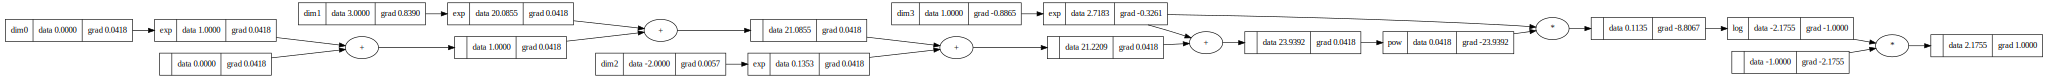

In [147]:
draw_dot(loss)

In [164]:
# verify the gradient using the torch library
# torch should give you the exact same gradient
import torch as t

logits = t.tensor([0.0, 3.0, -2.0, 1.0], dtype=t.float64, requires_grad=True)
softmax = t.nn.Softmax(dim=0)
probs = softmax(logits)
loss = -probs[3].log()
loss.backward()

logits.grad


tensor([ 0.0418,  0.8390,  0.0057, -0.8865], dtype=torch.float64)